# Rule Trends - by Location
Andrew Reichel



List:
- MBA All Trans

TODO:
- MBA All Returns

### Configure libraries and load dataset (previously aggregated into csv from discrete xlsx)

In [1]:
import pandas as pd
import sys, os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

''' setup paths '''
data_dir = '../data/'

for doc in os.listdir(data_dir):
    if doc.endswith('csv'):
        df_0911 = pd.read_csv(os.path.join(data_dir,doc),index_col=0)
df_0911.head()

In [95]:
df_0911.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Establish frunctions to prep data and mine rules

In [4]:
def cleanup_df(df_in):
    ''' clean up DESCRIPTION col of df_in to:
            1. remove spaces
            2. drop rows w/o invoice numbers
            3. drop postage row
            4. remove returned transactions (C) '''
    # drop extra spaces
    df_in.loc[:,'Description'] = df_in.loc[:,'Description'].str.strip()
    # drop rows w/o invoice number
    #df_in.dropna(axis=0, subset=['Invoice'], inplace=True)
    df_in.loc[:,'Invoice'] = df_in.loc[:,'Invoice'].astype(str)
    # drop postage row
    #df_in = df_in.Description.drop('POSTAGE', axis = 0)
    # drop Invoice == 'C' rows
    df_in = df_in[~df_in.loc[:,'Invoice'].str.contains('C')]
    
    return df_in

def encode_purch(item):
    ''' set all instances of purchase to 1, else == 0
        drop postage column '''
    if item >= 1:
        return 1
    else:
        return 0

def make_basket(df_in):
    ''' setup basket for MBA 
            1. One Hot Encode transactions 
            2. '''
    df_cleaned = cleanup_df(df_in)
    basket = (df_cleaned.groupby(['Invoice','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0).set_index('Invoice'))
    
    basket = basket.applymap(encode_purch)
    #print basket.POSTAGE
    if 'POSTAGE' in basket.columns:
        basket = basket.drop('POSTAGE', axis = 1)
    return basket

def mine_rules(country, min_supp = 'NA', verbose = False):  
    ''' function to extract rules or perform min_supp sensitivity test if no
        min_supp is provided '''
    # find orders by country
    df_country = df_0911[df_0911.Country == country]
    
    # make baskets
    baskets = make_basket(df_country)
    print "len of basket: ",len(baskets)
    
    ''' if min_supp not given, run sensitivity test on minsupp, else find
        all association rules '''
    if min_supp == 'NA':
        items = {}
        for min_sup in np.linspace(0.41, 0.02, 35):
            frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
            items[min_sup] = len(frq_itms)
            if verbose == True:
                print "Considering Min_Supp: {}: {}".format(min_sup, len(frq_itms))
        freq_items = pd.DataFrame.from_dict(items, orient='index')
        return items
    else:
        freq_items = apriori(baskets, min_support=min_supp, use_colnames=True)
        rules = association_rules(freq_items, metric='confidence', min_threshold=0.35)
        return rules


### Test on USA Orders 

In [96]:
df_USorders = df_0911[df_0911.Country == 'USA']
print "US Orders: ", len(df_USorders.Invoice.unique())
df_USorders.head()

US Orders:  25


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
51589,494110,21268,VINTAGE BLUE TINSEL REEL,24,2010-01-11 12:29:00,2.10,12549.0,USA
51590,494110,21412,VINTAGE GOLD TINSEL REEL,11,2010-01-11 12:29:00,0.42,12549.0,USA
51591,494110,22083,PAPER CHAIN KIT RETRO SPOT,6,2010-01-11 12:29:00,2.95,12549.0,USA
51592,494110,22084,PAPER CHAIN KIT EMPIRE,6,2010-01-11 12:29:00,2.95,12549.0,USA


In [97]:
print make_basket(df_USorders).shape
baskets = make_basket(df_USorders)
baskets.head()

(20, 303)


Description,12 PENCILS SMALL TUBE RED RETROSPOT,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,60 CAKE CASES DOLLY GIRL DESIGN,...,VINTAGE UNION JACK BUNTING,VINTAGE UNION JACK SHOPPING BAG,WOOD STAMP SET BEST WISHES,WOODLAND DESIGN COTTON TOTE BAG,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP WEDDING DAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494891,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


(0.42, 0.04)

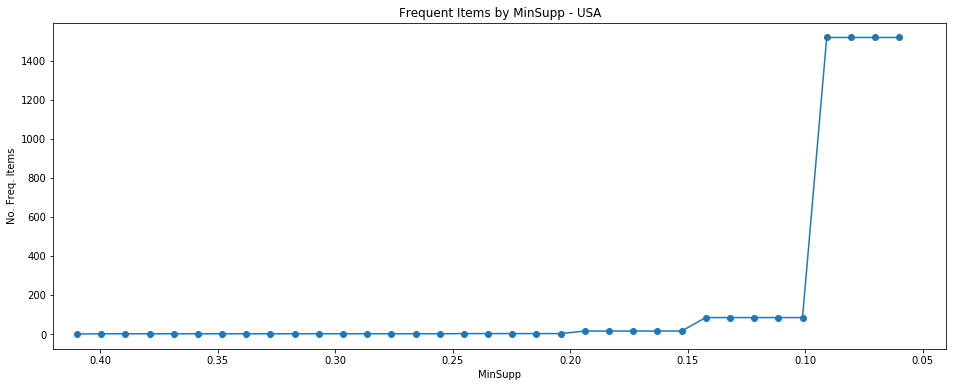

In [98]:
''' find minsupp sensitivity '''
items = {}
for min_sup in np.linspace(0.41, 0.06, 35):
    #print "Considering Min_Supp: ", min_sup
    frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
    items[min_sup] = len(frq_itms)

freq_items = pd.DataFrame.from_dict(items, orient='index')

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_title('Frequent Items by MinSupp - USA')
ax.set_xlabel('MinSupp')
ax.set_ylabel('No. Freq. Items')
ax.scatter(freq_items.index, freq_items.iloc[:,0])
ax.plot(freq_items.sort_index())
ax.set_xlim(0.42, 0.04)

### Find ideal min_supp, by country

In [119]:
print "Unique Countries in Data: {}".format(len(df_0911.Country.unique()))

country_ords = {}
for country in df_0911.Country.unique():
    tmp = df_0911[df_0911.Country == country]
    #print country, len(tmp)
    country_ords[country] = len(tmp.Invoice.unique())

df_ords_Country = pd.DataFrame.from_dict(country_ords, orient='index',columns=['Order Count'])

Unique Countries in Data: 43


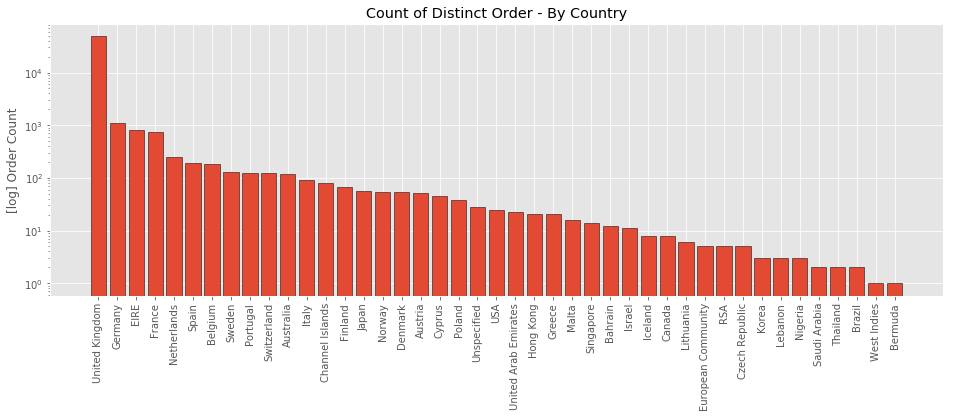

In [123]:
''' plot of Order Count by Country '''
plt.style.use('ggplot')
df_ords_Country = df_ords_Country.sort_values(['Order Count'], axis=0, ascending=False)
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_title('Count of Distinct Order - By Country')
ax.set_ylabel('[log] Order Count')
ax.bar(df_ords_Country.index,df_ords_Country['Order Count'],edgecolor='black')
plt.yscale('log')
plt.xticks(rotation = 90);

### Identify Top 5 countries for rule mining

In [125]:
df_ords_Country = df_ords_Country.sort_values(by=['Order Count'], axis=0, ascending=False)
top_countries = df_ords_Country.index[:5]

In [126]:
min_sup_df = pd.DataFrame()

In [78]:
rules_cnt_dict = {}
for locale in top_countries:
    if locale not in min_sup_df.columns and locale not in rules_cnt_dict.keys():
        print locale
        #rules_cnt = mine_rules(locale)
        rules_cnt_dict[locale] = mine_rules(locale)

United Kingdom
len of basket:  37518
Germany
len of basket:  789
EIRE
len of basket:  626
France
len of basket:  622
Netherlands
len of basket:  229


In [79]:
for i in rules_cnt_dict:
    tmp_df = pd.DataFrame.from_dict(rules_cnt_dict[i],orient='index',columns=[i]).sort_values(i,axis=0,
                                                                                              ascending = False)
    #print tmp_df
    min_sup_df[i] = tmp_df[i]

print min_sup_df.head()
''' write to csv '''
min_sup_df.to_csv('../results/freq_item_count.csv')

          United Kingdom  EIRE  Netherlands  Germany  France
0.020000             249   612        13874      501     878
0.031471              71   203          922      167     268
0.042941              31    99          364       80     126
0.054412              10    41          150       41      76
0.065882               5    20           67       24      50


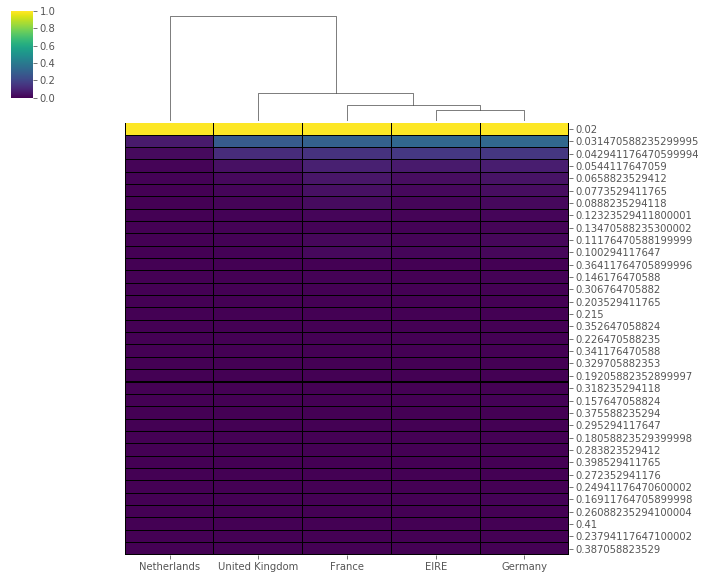

In [144]:
''' plot of freq items by min supp '''
min_sup_df = pd.read_csv('../results/freq_item_count.csv', index_col=0)
sns.clustermap(min_sup_df,standard_scale=1, row_cluster=False, cmap = 'viridis', 
               linewidth=0.005, linecolor='black');

### Loop through 3 countries, finding rules

In [146]:
''' read in min supp thresholds '''
sens_df = pd.read_csv(os.path.join(os.getcwd(),'..','results','freq_item_count.csv'))

In [147]:
countries = []
for doc in os.listdir(os.path.join(os.getcwd(),'../results/rules')):
    countries.append(doc.split('_')[0])

In [89]:
rules = {}
rules_path = os.path.join(os.getcwd(),'../results/rules/')
min_sup = 0.025
for locale in top_countries:
    if locale not in countries and locale not in skip:
        print locale
        file_name = '{}_minsup{}_rules.csv'.format(locale,min_sup)
        rules_gen = mine_rules(locale, min_supp=min_sup).sort_values('confidence', ascending=False)
        if len(rules_gen) > 0:
            rules[locale] = rules_gen
        

        print "Writing {} rules to {}".format(locale,os.path.join(rules_path,file_name))
        rules_export = pd.DataFrame.from_dict(rules_gen)#, orient='index')
        rules_export.to_csv(os.path.join(rules_path,file_name))

United Kingdom
len of basket:  37518
Writing United Kingdom rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/United Kingdom_minsup0.025_rules.csv
Germany
len of basket:  789
Writing Germany rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/Germany_minsup0.025_rules.csv
EIRE
len of basket:  626
Writing EIRE rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/EIRE_minsup0.025_rules.csv
France
len of basket:  622
Writing France rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/France_minsup0.025_rules.csv
Netherlands
len of basket:  229
Writing Netherlands rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/Netherlands_minsup0.025_rules.csv


In [90]:
rules_gen

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15520,"(DOLLY GIRL LUNCH BOX, ROUND SNACK BOXES SET O...",(SPACEBOY LUNCH BOX),0.026201,0.205240,0.026201,1.00,4.872340,0.020823,inf
22962,"(FOOD CONTAINER SET 3 LOVE HEART, 60 CAKE CASE...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.026201,0.196507,0.026201,1.00,5.088889,0.021052,inf
15573,"(WOODLAND CHARLOTTE BAG, LUNCH BAG RED RETROSP...","(SPACEBOY BIRTHDAY CARD, ROUND SNACK BOXES SET...",0.026201,0.069869,0.026201,1.00,14.312500,0.024370,inf
15577,"(WOODLAND CHARLOTTE BAG, SPACEBOY BIRTHDAY CAR...","(ROUND SNACK BOXES SET OF4 WOODLAND, PLASTERS ...",0.026201,0.078603,0.026201,1.00,12.722222,0.024141,inf
6273,"(SPACEBOY LUNCH BOX, CARD DOLLY GIRL)",(DOLLY GIRL LUNCH BOX),0.043668,0.183406,0.043668,1.00,5.452381,0.035659,inf
6269,"(LUNCH BAG RED RETROSPOT, STRAWBERRY LUNCH BOX...",(FOOD CONTAINER SET 3 LOVE HEART),0.030568,0.109170,0.030568,1.00,9.160000,0.027231,inf
6268,"(LUNCH BAG RED RETROSPOT, FOOD CONTAINER SET 3...",(STRAWBERRY LUNCH BOX WITH CUTLERY),0.030568,0.100437,0.030568,1.00,9.956522,0.027498,inf
22936,"(ROUND SNACK BOXES SET OF4 WOODLAND, LUNCH BOX...",(STRAWBERRY LUNCH BOX WITH CUTLERY),0.026201,0.100437,0.026201,1.00,9.956522,0.023569,inf
19469,"(LUNCH BAG RED RETROSPOT, PLASTERS IN TIN SPAC...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.034934,0.196507,0.034934,1.00,5.088889,0.028070,inf
22938,"(ROUND SNACK BOXES SET OF4 WOODLAND, JUMBO BAG...",(LUNCH BOX WITH CUTLERY RETROSPOT),0.026201,0.078603,0.026201,1.00,12.722222,0.024141,inf


In [85]:
mine_rules('United Kingdom', min_supp=0.05/2)

len of basket:  37518


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.037529,0.057279,0.026414,0.703835,12.287804,0.024264,3.183096
1,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.057279,0.037529,0.026414,0.461145,12.287804,0.024264,1.786141
2,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.044592,0.140093,0.031318,0.702331,5.013329,0.025071,2.888805
3,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.056026,0.051549,0.026387,0.470980,9.136623,0.023499,1.792846
4,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.051549,0.056026,0.026387,0.511892,9.136623,0.023499,1.933946
5,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.056186,0.081294,0.025988,0.462524,5.689497,0.021420,1.709295
6,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE),0.052082,0.053308,0.029053,0.557830,10.464335,0.026276,2.141015
7,(WOODEN FRAME ANTIQUE WHITE),(WOODEN PICTURE FRAME WHITE FINISH),0.053308,0.052082,0.029053,0.545000,10.464335,0.026276,2.083337
8,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.059411,0.081294,0.028200,0.474652,5.838690,0.023370,1.748757


### Rules Comparison

In [93]:
''' read in rules of top countries '''
rules_dir = os.path.join(os.getcwd(),'..','results','rules')

for i in os.listdir(rules_dir)[:1]:
    print i.split('_')[0]
    df = pd.read_csv(os.path.join(rules_dir,i),index_col=0)
    print df.head()

Germany
                                           antecedants  \
141            frozenset(['COFFEE MUG PEARS  DESIGN'])   
134  frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND...   
0        frozenset(['SWEETHEART CERAMIC TRINKET BOX'])   
102  frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'...   
29                     frozenset(['BLUE SPOTTY BOWL'])   

                                           consequents  antecedent support  \
141            frozenset(['COFFEE MUG APPLES DESIGN'])            0.031686   
134   frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])            0.034221   
0        frozenset(['STRAWBERRY CERAMIC TRINKET BOX'])            0.032953   
102  frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])            0.030418   
29                      frozenset(['RED SPOTTY BOWL'])            0.029151   

     consequent support   support  confidence       lift  leverage  conviction  
141            0.063371  0.029151    0.920000  14.517600  0.027143   11.707858  
134         

In [92]:
pd.read_csv(os.path.join(rules_dir,i))

,Unnamed: 0,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,141,frozenset(['COFFEE MUG PEARS DESIGN']),frozenset(['COFFEE MUG APPLES DESIGN']),0.031686,0.063371,0.029151,0.920000,14.517600,0.027143,11.707858
1,134,frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND...,frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS']),0.034221,0.169835,0.030418,0.888889,5.233831,0.024606,7.471483
2,0,frozenset(['SWEETHEART CERAMIC TRINKET BOX']),frozenset(['STRAWBERRY CERAMIC TRINKET BOX']),0.032953,0.064639,0.029151,0.884615,13.685520,0.027021,8.106464
3,102,frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'...,frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND']),0.030418,0.262357,0.026616,0.875000,3.335145,0.018636,5.901141
4,29,frozenset(['BLUE SPOTTY BOWL']),frozenset(['RED SPOTTY BOWL']),0.029151,0.039290,0.025349,0.869565,22.131837,0.024203,7.365441
5,24,frozenset(['RED RETROSPOT CHARLOTTE BAG']),frozenset(['WOODLAND CHARLOTTE BAG']),0.046895,0.166033,0.040558,0.864865,5.208995,0.032772,6.171356
6,135,"frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT',...",frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND']),0.035488,0.262357,0.030418,0.857143,3.267081,0.021108,5.163498
7,85,frozenset(['CHARLOTTE BAG SUKI DESIGN']),frozenset(['WOODLAND CHARLOTTE BAG']),0.048162,0.166033,0.040558,0.842105,5.071916,0.032561,5.281791
8,22,frozenset(['SET/6 RED SPOTTY PAPER CUPS']),frozenset(['SET/6 RED SPOTTY PAPER PLATES']),0.055767,0.057034,0.046895,0.840909,14.743939,0.043714,5.927213
9,71,"frozenset(['WOODLAND CHARLOTTE BAG', 'ROUND SN...",frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND']),0.054499,0.262357,0.045627,0.837209,3.191102,0.031329,4.531233
